<a href="https://colab.research.google.com/github/heugyu/coin_deep_learning/blob/master/DataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 구글 드라이브 마운트 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib
import matplotlib.pyplot as plt

In [7]:
# 구글 드라이브 csv read
data = pd.read_csv('/content/drive/My Drive/DATA/BINANCE_BTCUSDT, 30.csv')
print(f'데이터 shape : {data.shape}')
data.head()

데이터 shape : (20457, 49)


,time,open,high,low,close,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA
0,1546300800,3701.23,3703.72,3689.88,3694.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3695.933333,3747.319315,322.716816,NaN,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,7.277674e+07,0.000000e+00,NaN,NaN,NaN,NaN
1,1546302600,3693.96,3713.00,3693.00,3700.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3699.202317,3747.319315,363.650604,NaN,293265.548412,4.905579e+05,55599.891894,101401.563275,6.256120e+05,4721.332087,578859.756320,709500.031334,13555.986530,164492.536833,44019.496881,13917.635647,0.0,0.0,0.0,0.0,8.162056e+07,3.645190e+08,NaN,NaN,NaN,NaN
2,1546304400,3700.20,3702.73,3691.22,3699.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3698.781904,3747.319315,275.191465,NaN,23383.892564,5.151579e+05,63347.057885,53173.586629,1.105990e+05,1194.206875,275921.138045,589702.559597,490.436390,135582.245094,11383.580919,6382.902702,0.0,0.0,0.0,0.0,8.406477e+07,2.487707e+08,NaN,NaN,NaN,NaN
3,1546306200,3699.08,3700.00,3684.22,3689.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3696.835336,3744.026211,338.347650,NaN,410822.308402,1.044291e+06,64155.479063,136715.379235,1.523040e+06,6895.989269,797655.454961,657379.636085,1937.348583,108666.368200,92445.143552,46392.131513,0.0,0.0,0.0,0.0,1.040063e+08,6.018173e+08,NaN,NaN,NaN,NaN
4,1546308000,3689.67,3695.95,3675.04,3686.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,3693.706328,3744.026211,519.488423,NaN,150882.835199,1.187962e+05,146553.666400,110887.171512,4.401011e+05,300.498169,493953.540195,790138.887097,4415.778053,57875.411815,25785.704202,7209.289655,0.0,0.0,0.0,0.0,8.810869e+07,2.561461e+08,NaN,NaN,NaN,NaN


#### pandas 
- dataframe.shape -> 행열의 개수 
- dataframe.index -> 행이 어떻게 이루어져 있는지 
- dataframe.columns -> 열이 어떻게 이루어져 있는지  

In [10]:
data[['time', 'open', 'high', 'low', 'close']].head()

,time,open,high,low,close
0,1546300800,3701.23,3703.72,3689.88,3694.20
1,1546302600,3693.96,3713.00,3693.00,3700.31
2,1546304400,3700.20,3702.73,3691.22,3699.25
3,1546306200,3699.08,3700.00,3684.22,3689.69
4,1546308000,3689.67,3695.95,3675.04,3686.64


In [23]:
# UNIX TIME CONVERT
data.time = pd.to_datetime(data.time, format='%Y-%m-%d %H:%M:%S')
# Describe 
# 기본 데이터 이외에는 NaN 값 존재 na를 제거 해야함 
data.describe()

,open,high,low,close,H,M,L,wca,RES,SUP,Shapes,Shapes.1,EMA_34,EMA_90,EMA_100,EMA_144,EMA_200,short_line,RES.1,RES_CLOSE,SUP.1,SUP_CLOSE,VWAP,34 EMA,Volume,Volume MA,Bitfinex (USD),Coinbase (USD),Bitstamp (USD),Kraken (USD),HitBTC (USD),CEX.io (USD),Binance (USDT),Bittrex (USDT),Poloniex (USDT),bitFlyer (JPY),Bithumb (KRW),Korbit (KRW),Kraken (EUR),Bitfinex (EUR),Bitstamp (EUR),Coinbase (EUR),Volume.1,A/D Volume,Volume EMA,A/D Volume EMA,A/D Buy MA,A/D Sell MA
count,20457.000000,20457.000000,20457.000000,20457.000000,20439.000000,20429.000000,20439.000000,0.0,0.0,0.0,0.0,0.0,20424.000000,20368.000000,20358.000000,20314.000000,20258.000000,20423.000000,20457.000000,20457.000000,20457.000000,20457.000000,20457.000000,20457.000000,20457.000000,20438.000000,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045700e+04,2.045100e+04,2.045100e+04,1.052900e+04,9.915000e+03
mean,7586.935710,7611.892566,7560.104324,7587.168692,7811.293832,7585.678113,7356.293426,NaN,NaN,NaN,NaN,NaN,7589.330187,7592.987286,7593.631996,7596.509258,7600.110886,7592.758180,7777.563299,7756.280104,7324.822832,7351.460053,6315.108712,7570.996746,917.881532,917.668291,7.210491e+05,8.982261e+05,5.362103e+05,4.316231e+05,1.447284e+06,1.395061e+04,3.047026e+06,3.061884e+06,8.927909e+04,3.492064e+05,4.251172e+05,3.838382e+04,3.377680e+05,6.000029e+04,1.033062e+05,1.213342e+05,3.399060e+08,2.056004e+09,3.398805e+08,2.056138e+09,2.053414e+09,2.057959e+09
std,2527.783001,2540.584881,2513.472677,2527.648037,2643.426881,2524.886990,2415.013050,NaN,NaN,NaN,NaN,NaN,2523.835323,2517.736710,2516.699949,2512.061904,2506.045773,2529.469694,2659.816068,2648.170626,2413.863467,2426.400347,1902.275198,2524.219049,945.752573,560.099814,2.388080e+06,2.417965e+06,1.263408e+06,1.801308e+06,2.484545e+06,5.050927e+04,5.365308e+06,5.354771e+06,2.058486e+05,7.205569e+05,1.764531e+06,2.083111e+06,8.850693e+05,2.197695e+05,2.680098e+05,3.632747e+05,4.224836e+08,4.004946e+09,3.086705e+08,2.402705e+09,1.996777e+09,2.060770e+09
min,3366.630000,3374.990000,3349.920000,3366.410000,3431.985979,3403.893262,3352.922161,NaN,NaN,NaN,NaN,NaN,3400.027777,3409.091568,3410.687817,3417.211680,3423.959938,1528.711578,0.000000,0.000000,0.000000,0.000000,3619.538664,3415.962794,20.361211,193.573744,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.067346e+07,0.000000e+00,2.860859e+07,5.623169e+07,1.417819e+08,1.049404e+08
25%,5218.820000,5231.770000,5205.780000,5218.850000,5334.678516,5214.854547,5076.571729,NaN,NaN,NaN,NaN,NaN,5231.251896,5218.324291,5215.814766,5216.176279,5229.621809,5234.085951,5295.000000,5281.980000,5085.750000,5110.750000,4033.775649,5172.390716,410.908998,539.808628,5.699344e+04,1.002173e+05,6.082020e+04,4.337557e+04,1.973814e+05,1.051933e+03,5.754704e+05,5.879467e+05,5.360551e+03,4.220894e+04,4.038954e+04,1.521125e+03,3.612587e+04,4.218482e+03,9.512723e+03,1.060500e+04,1.246021e+08,3.469637e+08,1.499270e+08,7.288055e+08,8.225875e+08,8.355240e+08
50%,8068.100000,8093.930000,8040.470000,8069.390000,8270.388891,8063.920667,7842.228619,NaN,NaN,NaN,NaN,NaN,8071.898777,8069.561797,8074.966233,8081.491712,8094.355629,8078.202793,8264.290000,8246.600000,7773.000000,7804.990000,7260.993723,8069.459161,635.168999,762.304648,1.828678e+05,2.804163e+05,1.762243e+05,1.362143e+05,6.580660e+05,3.412613e+03,1.433583e+06,1.463116e+06,2.315444e+04,1.281803e+05,1.241026e+05,5.901425e+03,1.177889e+05,1.480240e+04,3.207149e+04,3.584125e+04,2.211878e+08,9.124117e+08,2.546388e+08,1.349804e+09,1.483989e+09,1.482157e+09
75%,9604.960000,9634.110000,9572.130000,9604.700000,9899.886788,9634.288440,9362.375166,NaN,NaN,NaN,NaN,NaN,9606.857301,9653.609129,9656.836928,9680.006916,9708.71

In [0]:
# 일단, 기본 정보만 출려
test_data = data[['open', 'high', 'low', 'close']]

In [65]:
# MINMAX Scale 적용 가격은 전체에 스케일러 1개만 있으면 될듯 
price_scaler = MinMaxScaler()
test_data = pd.DataFrame(price_scaler.fit_transform(test_data), columns=test_data.columns)
test_data

,open,high,low,close
0,0.031584,0.031027,0.032470,0.030940
1,0.030897,0.031903,0.032768,0.031517
2,0.031486,0.030933,0.032598,0.031417
3,0.031381,0.030676,0.031929,0.030514
4,0.030492,0.030294,0.031052,0.030226
...,...,...,...,...
20452,0.512691,0.511859,0.514478,0.509192
20453,0.509066,0.508606,0.511275,0.506876
20454,0.506868,0.520044,0.508643,0.504536
20455,0.504526,0.509203,0.510987,0.508441


In [0]:
x = np.array(test_data)
y = np.array(test_data[['close']])

In [0]:
# 파라미터
INPUT_SIZE = 4     # input dimension
HIDDEN_SIZE = 8    # hidden dimension
BATCH_SIZE = 2
LENGTH = 7
LR = 0.01
EPOCHS = 500

In [0]:
dataX = []
dataY = []

for i in range(0, len(y) - LENGTH):
    _x = x[i:i + LENGTH]
    _y = y[i + LENGTH]
    # print(f'{_x} -> {_y}')
    dataX.append(_x)
    dataY.append(_y)

# train/test split 
train_size = int(len(dataY) * 0.7)
test_size = len(dataY) - train_size

trainX = torch.Tensor(np.array(dataX[0:train_size]))
trainX = Variable(trainX)
testX = torch.Tensor(np.array(dataX[train_size:len(dataX)]))
testX = Variable(testX)

trainY = torch.Tensor(np.array(dataY[0:train_size]))
trainY = Variable(trainY)
testY = torch.Tensor(np.array(dataY[train_size:len(dataY)]))
testY = Variable(testY)


In [81]:
print(trainX.shape)
print(trainY.shape)

print(testX.shape)
print(testY.shape)

torch.Size([14315, 7, 4])
torch.Size([14315, 1])
torch.Size([6135, 7, 4])
torch.Size([6135, 1])


In [0]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(
                input_size=input_size, 
                hidden_size=hidden_size,
                num_layers=num_layers,
                batch_first=True
                )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Intitialize hidden and cell states
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        # Propagte inpur through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        out = self.fc(h_out)
        return out


In [95]:
# Instantiate RNN model
lstm = LSTM(1, INPUT_SIZE, HIDDEN_SIZE, 1, LENGTH)

# Set loss and optimizer function
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm.parameters(), lr=LR)

# Train the model
for epoch in range(EPOCHS):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    #obtain the loss function
    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()
    print(f'Epoch : {epoch}, loss : {loss.data.item()}')


Epoch : 0, loss : 0.3257838189601898
Epoch : 1, loss : 0.2629803419113159
Epoch : 2, loss : 0.20490042865276337
Epoch : 3, loss : 0.15200065076351166
Epoch : 4, loss : 0.10517862439155579
Epoch : 5, loss : 0.06589847803115845
Epoch : 6, loss : 0.036137182265520096
Epoch : 7, loss : 0.018093403428792953
Epoch : 8, loss : 0.013403226621448994
Epoch : 9, loss : 0.02106270007789135
Epoch : 10, loss : 0.03425392135977745
Epoch : 11, loss : 0.04341629520058632
Epoch : 12, loss : 0.04481744021177292
Epoch : 13, loss : 0.04005115479230881
Epoch : 14, loss : 0.03225228190422058
Epoch : 15, loss : 0.02415858954191208
Epoch : 16, loss : 0.01749206706881523
Epoch : 17, loss : 0.012960091233253479
Epoch : 18, loss : 0.010527286678552628
Epoch : 19, loss : 0.009747600182890892
Epoch : 20, loss : 0.010034636594355106
Epoch : 21, loss : 0.010830413550138474
Epoch : 22, loss : 0.011685578152537346
Epoch : 23, loss : 0.012282543815672398
Epoch : 24, loss : 0.012429632246494293
Epoch : 25, loss : 0.01204

Learning finished!


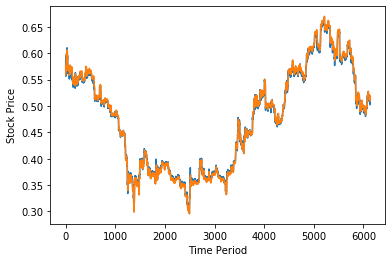

In [96]:
print("Learning finished!")
# Test the model
lstm.eval()
test_predict = lstm(testX)

# Plot predictions
test_predict = test_predict.data.numpy()
testY = testY.data.numpy()
plt.plot(testY)
plt.plot(test_predict)
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()